In [134]:
import pandas as pd  # Para manipulação de dados tabulares
import numpy as np  # Para computação numérica eficiente
import matplotlib.pyplot as plt  # Para plotagem de gráficos
import scipy.stats as stats  # Para estatísticas
import seaborn as sns  # Para visualização de dados
from sklearn.cluster import KMeans  # Para clustering
from sklearn.preprocessing import StandardScaler  # Para pré-processamento de dados
from sklearn.decomposition import PCA  # Para redução de dimensionalidade
from sklearn.impute import SimpleImputer  # Para imputação de valores ausentes

In [101]:
# Carregar os dados
df_normal = pd.read_csv('arquivo_sem_ataque.csv')
df_ataque = pd.read_csv('arquivo_com_ataque.csv')

# Converter a coluna 'hora' para datetime
df_normal['hora'] = pd.to_datetime(df_normal['hora'])
df_ataque['hora'] = pd.to_datetime(df_ataque['hora'])

C:\Users\Acer\AppData\Local\Temp\ipykernel_17000\2448451389.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_normal = pd.read_csv('arquivo_sem_ataque.csv')


In [92]:
df_normal.columns

Index(['hora', 'ip', 'metodo', 'protocolo', 'hostname', 'uri', 'querystring',
       'status_code', 'f0_', 'useragent', 'tamanho_request',
       'tamanho_resposta', 'organizacao', 'pais', 'cidade', 'cookie_sessao',
       'fingerprint1', 'fingerprint2', 'fingerprint3'],
      dtype='object')

In [102]:
# Contar o número de requisições por intervalo de 5 segundos
df_normal.set_index('hora', inplace=True)
df_ataque.set_index('hora', inplace=True)

# Resample (agregação) a cada 5 segundos
df_normal_resampled = df_normal.resample('5S').size()
df_ataque_resampled = df_ataque.resample('5S').size()


# Estatísticas descritivas do tráfego normal
print(df_normal_resampled.describe())

# Estatísticas descritivas do tráfego com ataque
print(df_ataque_resampled.describe())




count     1440.000000
mean       637.171528
std        723.055929
min        179.000000
25%        378.750000
50%        458.000000
75%        620.000000
max      10444.000000
dtype: float64
count     1440.000000
mean       242.266667
std        641.716583
min         41.000000
25%        140.000000
50%        190.000000
75%        244.000000
max      15077.000000
dtype: float64


In [103]:
# Conferir a distribuição da derivada (variação de acessos a cada 5 segundos)
df_normal_resampled_derivada = df_normal_resampled.copy()
df_normal_resampled_derivada = df_normal_resampled_derivada.reset_index()

df_ataque_resampled_derivada = df_ataque_resampled.copy()
df_ataque_resampled_derivada = df_ataque_resampled_derivada.reset_index()

# Criação da derivada para cada grupo
## Sem ataque
df_normal_resampled_derivada['derivada'] = df_normal_resampled_derivada[0].diff()
df_normal_resampled_derivada = df_normal_resampled_derivada.dropna()

## Com ataque
df_ataque_resampled_derivada['derivada'] = df_ataque_resampled_derivada[0].diff()
df_ataque_resampled_derivada = df_ataque_resampled_derivada.dropna()

(array([  1.,   0.,   0.,   1.,   3.,   3.,  17.,  36., 152., 718., 386.,
         95.,  16.,   5.,   4.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-1687.  , -1514.72, -1342.44, -1170.16,  -997.88,  -825.6 ,
         -653.32,  -481.04,  -308.76,  -136.48,    35.8 ,   208.08,
          380.36,   552.64,   724.92,   897.2 ,  1069.48,  1241.76,
         1414.04,  1586.32,  1758.6 ,  1930.88,  2103.16,  2275.44,
         2447.72,  2620.  ,  2792.28,  2964.56,  3136.84,  3309.12,
         3481.4 ,  3653.68,  3825.96,  3998.24,  4170.52,  4342.8 ,
         4515.08,  4687.36,  4859.64,  5031.92,  5204.2 ,  5376.48,
         5548.76,  5721.04,  5893.32,  6065.6 ,  6237.88,  6410.16,
         6582.44,  6754.72,  6927.  ]),
 <BarContainer object of 50 artists>)

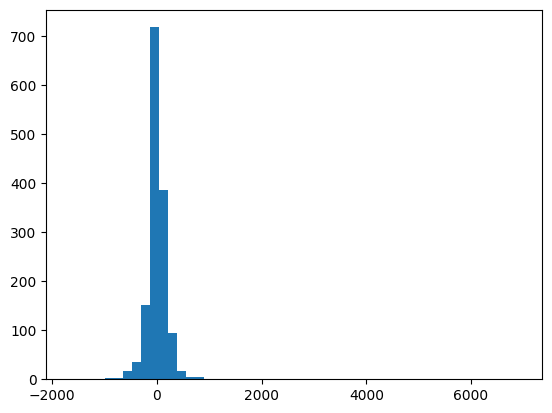

In [135]:
# Plotar histograma da distribuição esperada de acessos normais
plt.hist(df_normal_resampled_derivada['derivada'], bins=50)

In [96]:
# Usar CDF para a probabilidade acumulada
def prob_ataque(valor):
    cumulative_probability = stats.norm.cdf(valor, mu, sigma)
    if cumulative_probability <= 0.05:
        return True
    else:
        return False

In [104]:
# Parâmetros da distribuição normal para sem ataque
mu =  np.mean(df_normal_resampled_derivada['derivada'])    # Média
sigma = np.std(df_normal_resampled_derivada['derivada'])  # Desvio padrão


In [105]:
# Identificar quando começou o ataque:
df_ataque_resampled_derivada["ataque"] = df_ataque_resampled_derivada['derivada'].apply(prob_ataque)

In [106]:
df_ataque_resampled_derivada

,hora,0,derivada,ataque
1,2024-05-15 14:00:05+00:00,182,-168.0,False
2,2024-05-15 14:00:10+00:00,258,76.0,False
3,2024-05-15 14:00:15+00:00,211,-47.0,False
4,2024-05-15 14:00:20+00:00,123,-88.0,False
5,2024-05-15 14:00:25+00:00,153,30.0,False
...,...,...,...,...
1435,2024-05-15 15:59:35+00:00,268,147.0,False
1436,2024-05-15 15:59:40+00:00,169,-99.0,False
1437,2024-05-15 15:59:45+00:00,99,-70.0,False
1438,2024-05-15 15:59:50+00:00,86,-13.0,False


In [136]:
primeiro_ataque_index = df_ataque_resampled_derivada[df_ataque_resampled_derivada['ataque'] == True].index[0]

# Obter o valor da coluna 'hora' correspondente ao índice encontrado
primeira_hora_ataque = df_ataque_resampled_derivada.loc[primeiro_ataque_index, 'hora']

print("O primeiro momento detectado do ataque foi em:", primeira_hora_ataque)

O primeiro momento detectado do ataque foi em: 2024-05-15 15:01:05+00:00


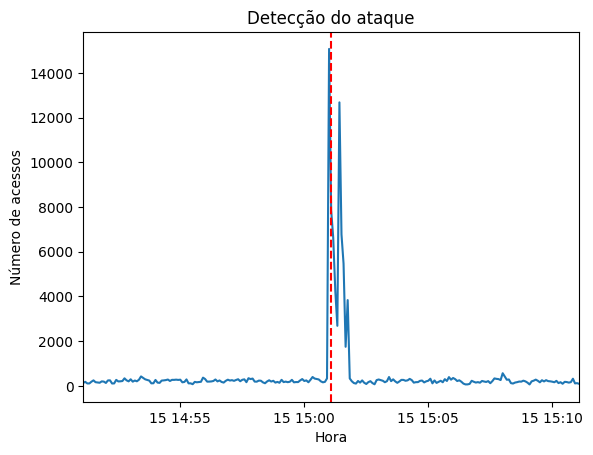

In [137]:
# Criar um objeto Timedelta para subtrair 10 unidades de tempo para facilitar a visualização
zoom_timedelta = pd.Timedelta(minutes=10)

# Calcular os limites de zoom
zoom_inicio = primeira_hora_ataque - zoom_timedelta
zoom_fim = primeira_hora_ataque + zoom_timedelta

# Criar o gráfico de linha com o zoom
plt.plot(df_ataque_resampled_derivada['hora'], df_ataque_resampled_derivada[0])
plt.axvline(x=primeira_hora_ataque, color='red', linestyle='--')

# Ajustar os limites do eixo x para o intervalo de zoom
plt.xlim(zoom_inicio, zoom_fim)

# Adicionar rótulos e título
plt.xlabel('Hora')
plt.ylabel('Número de acessos')
plt.title('Detecção do ataque')

# Mostrar o gráfico
plt.show()

In [138]:
# Preparação para filtrar o dataframe original
# Necessário devido à falta de memória RAM disponível

df_ataque_copia = df_ataque.copy()
df_ataque_copia = df_ataque_copia.reset_index()
df_ataque_copia.columns

Index(['hora', 'ip', 'metodo', 'protocolo', 'hostname', 'uri', 'querystring',
       'status_code', 'f0_', 'useragent', 'tamanho_request',
       'tamanho_resposta', 'organizacao', 'pais', 'cidade', 'cookie_sessao',
       'fingerprint1', 'fingerprint2', 'fingerprint3'],
      dtype='object')

In [139]:
# Filtragem do draframe original no período que ocorre o ataque

# Criar um objeto Timedelta para subtrair 10 unidades de tempo
zoom_timedelta = pd.Timedelta(minutes=30)

# Calcular os limites de zoom
zoom_inicio = primeira_hora_ataque - zoom_timedelta
zoom_fim = primeira_hora_ataque + zoom_timedelta

df_ataque_filtered = df_ataque_copia.loc[(df_ataque_copia['hora'] >= zoom_inicio) & (df_ataque_copia['hora'] <= zoom_fim)]

# Treinamento do modelo de clusterização para detecção dos atacantes

# Selecionar as colunas relevantes para o modelo
features = ['tamanho_request', 'tamanho_resposta', 'status_code', 'pais', 'cidade']
X = df_ataque_filtered[features]



# Codificar variáveis categóricas
X = pd.get_dummies(X, columns=['pais', 'cidade'], drop_first=True)

# Imputar valores ausentes
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

print(X_imputed)

[[5.82000000e+02 7.77000000e+02 2.00000000e+02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.60000000e+01 7.62540000e+04 2.00000000e+02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.70000000e+01 5.23000000e+02 2.00000000e+02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.54700000e+03 4.71571308e+04 4.04000000e+02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.63900000e+03 4.71571308e+04 4.04000000e+02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.60000000e+01 4.71571308e+04 4.04000000e+02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


d:\.pyspark-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Acer\AppData\Local\Temp\ipykernel_17000\2384541841.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ataque_filtered['cluster'] = kmeans.labels_


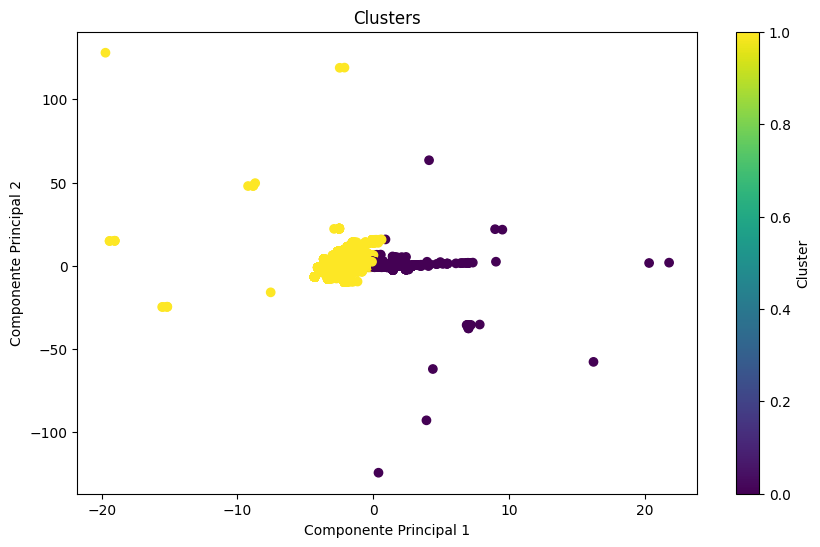

In [140]:
# Pré-processamento dos dados

# Imputar valores ausentes
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Redução de dimensionalidade
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Treinamento do modelo
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_pca)

# Adicionando rótulos de cluster aos dados
df_ataque_filtered['cluster'] = kmeans.labels_

# Visualização dos clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_ataque_filtered['cluster'])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters')
plt.colorbar(label='Cluster')
plt.show()